# 3. **makemore** (part 2): mlp

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    print("Cloning repo...")
    !git clone --quiet https://github.com/ckaraneen/micrograduate.git > /dev/null
    %cd micrograduate
    print("Installing requirements...")
    !pip install --quiet uv
    !uv pip install --system --quiet -r requirements.txt

## Intro

Time to make more out of **makemore**! In the last lesson, we implemented the bigram language model, both using counts and a super simple, 1-linear-layer **nn**. How we approach training is that we looked only at the single previous character and we predicted a distribution for the character coming next in the sequence. We did that by taking counts and normalizing them into probabilities so that each row in the count matrix sums to $1$. This method is great if you only have one character of previous context. The problem with that model though is that predictions are not very good. Another problem, if we are to take more context into account, is that the counts in the matrix grow exponentially as we increase the length of the context. For just $1$ character of context we have $27$ rows, each representing the next possible character. For $2$ characters, the number of rows would grow to $27 \cdot 27 = 729$. Whereas for $3$ characters, it would explode to $27 \cdot 27 \cdot 27 = 19683$, and so on. This solution simply doesn't scale well and explodes. That is why we are going to move on and instead implement an **mlp** model to predict the next character in a sequence.

## Building a **mlp** language model

The modeling approach we are going to adopt follows [Bengio et al. 2003](https://dl.acm.org/doi/10.5555/944919.944966), an important paper that we are going to implement. Although they implement a word-level language model, we are going to stick to our character-level language model, but follow the same approach. The authors propose associating each and every word (out of e.g. $17000$) with a feature vector (e.g. of $30$ dimensions). In other words, every word is a point that is embedded into a $30$-dimensional space. You can think of it this way. We have $17000$ point-vectors in a $30$-dimensional space. As you can imagine, that is very crowded, that's lots of points for a very small space. Now, in the beginning, these words are initialized completely randomly: they are spread out at random. But, then we are going to tune these embeddings of these words using **backprop**. So during the course of training of this **nn**, these point-vectors are going to basically be moved around in this space. And you might imagine that, for example, words that have very similar meanings or that are indeed synonyms of each other might end up in a very similar part of the vector space, and, conversely, words with very different meanings will go somewhere else in that space. Now, their modeling approach otherwise is identical to what ours has been so far. They are using a **mlp** **nn** to predict the next word, given the previous words and to train the **nn** they are maximizing the log-likehood of the training data, just like we did. Here, is their example of this intuition: suppose the exact phrase *`a dog was running in a`* has never occured and at test time we want our model to complete the sentence by predicting the word that might follow it (e.g. *`room`*). Because the model has never encountered this exact phrase in the training set, it is out of distribution, as we say. Meaning, you don't have fundamentally any reason to suspect what might come next. However, the approach we are following allows you to get around such suspicion. Maybe we haven't seen the exact phrase, but maybe we have seen similar phrases like: *`the dog was running in a`* and maybe your **nn** has learned that *`a`* and *`the`* are frequently interchangeble with each other. So maybe our model took the embeddings for *`a`* and *`the`* and it actually put them nearby eachother in the vector space. Thus, you can transfer knowledge through such an embedding and generalize in that way. Similarly, it can do the same with other similar words such that a phrase such as *`The cat is walking in the bedroom`* can help us generalize to a diserable or at least valid sentence like *`a dog was running in a`* **`room`** by merit of the magic of feature vector similarity after training! To put it more simply, manipulating the embedding space allows us to transfer knowledge, predict and generalize to novel scenarios even when fed inputs like the sequence of words mentioned that we have not trained on. If you scroll down the paper, you will see the following diagram:

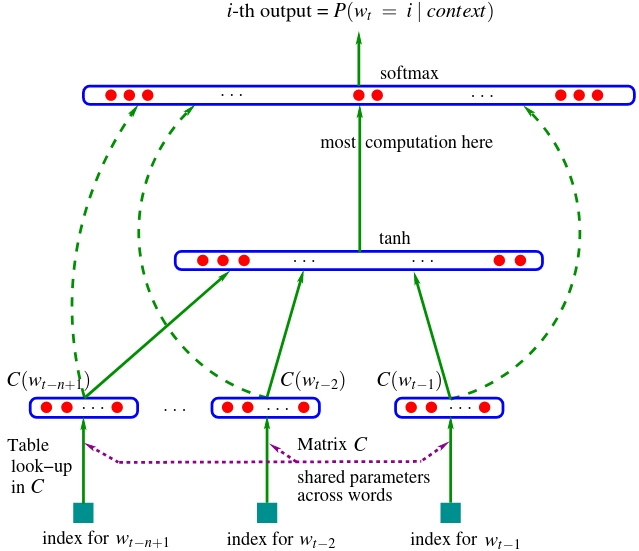

In [2]:
from IPython.display import Image, display
display(Image(filename='bengio2003nn.jpeg'))

This is the **nn** where we are taking e.g. three previous words and we are trying to predict the fourth word in a sequence, where $w_{t-3}$, $w_{t-2}$, $w_{t-1}$ are the indeces of each incoming word. Since there are $17000$ possible words, these indeces are integers between $0-16999$. There's also a lookup table $C$, a matrix that has $17000$ rows (one for each word embedding) and $30$ columns (one for each feature vector/embedding dimension). Every index basically plucks out a row of this embedding matrix so that each index is converted to the $30$-dimensional embedding vector corresponding to that word. Therefore, each word index corresponds to $30$ neuron activations exiting the first layer: $w_{t-3} \rightarrow C(w_{t-3})$, $w_{t-2} \rightarrow C(w_{t-2})$, $w_{t-1} \rightarrow C(w_{t-1})$. Thus, the first layer contains $90$ neurons in total. Notice how the $C$ matrix is shared, which means that we are indexing the same matrix over and over. Next up is the hidden layer of this **nn** whose size is a hyperparameter, meaning that it is up to the choice of the designer how wide, aka how many neurons, it is going to have. For example it could have $100$ or any other number that endows the **nn** with the best performance, after evaluation. This hidden layer is fully connected to the input layer of $90$ neurons, meaning each neuron is connected to each one of this layer's neurons. Then there's a $\tanh$ non-linearity, and then there's an output layer. And because of course we want the **nn** to give us the next word, the output layer has $17000$ neurons that are also fully connected to the previous (hidden) layer's neurons. So, there's a lot of parameters, as there are a lot of words, so most computation happens in the output layer. Each of this layer's $17000$ logits is passed through a $softmax$ function, meaning they are all exponentiated and then everything is normalized to sum to $1$, so that we have a nice probability distribution $P(w_{t}=i\ |\ context)$ for the next word $w_{t}$ in the sequence. During training of course, we have the label or target index: the index of the next word in the sequence which we use to pluck out the probability of that word from that distribution. The point of training is to maximize the probability of that word **w.r.t.** the **nn** parameters, meaning the weights and biases of the output layer, of the hidden layer and of the embedding lookup table $C$. All of these parameters are optimized using **backprop**. Ignore the green dashed arrows in the diagram, they represent a variation of the **nn** we are not going to explore in this lesson. So, what we  described is the setup. Now, let's implement it!

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
if IN_COLAB:
    %matplotlib inline
else:
    %matplotlib ipympl

In [4]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
ctoi = {c: i + 1 for i, c in enumerate(chars)}
ctoi["."] = 0
itoc = {i: c for c, i in ctoi.items()}
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


As you can see, we are reading `32033` words into a list and we are creating character-to/from-index mappings. From here, the first thing we want to do is compile the dataset for the **nn**:

In [7]:
# context length: how many characters do we take to predict the next one?
block_size = 3


def build_dataset(words, verbose=False):
    x, y = [], []
    for w in words:
        if verbose:
            print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = ctoi[ch]
            if verbose:
                print("".join(itoc[i] for i in context), "--->", itoc[ix])
            context = context[1:] + [ix]  # crop and append
            x.append(context)
            y.append(ix)
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(f"{x.shape=}, {y.shape=}")
    print(f"{x.dtype=}, {y.dtype=}")
    return x, y


x, y = build_dataset(words[:5], verbose=True)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .
x.shape=torch.Size([32, 3]), y.shape=torch.Size([32])
x.dtype=torch.int64, y.dtype=torch.int64


We first define the `block_size` which is how many characters we need to predict the next one. In the example I just described, we used $3$ words to predict the next one. Here, we also use a block size of $3$ and do the same thing, but remember, instead of words we expect characters as inputs and predictions. After defining the block size, we construct `x`: a feature list of word index triplets (e.g. `[[ 0,  0,  5], [ 0,  5, 13], ...]`) that represent the context inputs, and `y`: a list of corresponding target word indeces (e.g. `[ 5, 13, ...]`). In the printout above, you can see for each word's context character triplet, the corresponding target character. E.g. for an input of  `...` the target character is `e`, for `..e` it's `m`, and so on! Change the `block_size` and see the print out for yourself. Notice how we are using dots as padding. After building the dataset, inputs and targets look like this:

In [8]:
x, y

(tensor([[ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [13,  1,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 9,  1,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [22,  1,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1],
         [12,  1,  0],
         [ 0,  0, 19],
         [ 0, 19, 15],
         [19, 15, 16],
         [15, 16,  8],
         [16,  8,  9],
         [ 8,  9,  1],
         [ 9,  1,  0]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

Given these, let's write a **nn** that takes the `x` and predicts `y`. First, let's build the embedding lookup table `C`. In the paper, they have $17000$ words and embed them in spaces as low-dimensional as $30$, so they cram $17000$ into a $30$-dimensional space. In our case, we have only $27$ possible characters, so let's cram them into as small as -let's say- a $2$-dimensional space:

In [9]:
SEED = 2147483647
g = torch.Generator().manual_seed(SEED)
C = torch.randn((27, 2), generator=g)
C

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046],
        [-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.5618, -1.6261],
        [ 0.6772, -0.8404],
        [ 0.9849, -0.1484],
        [-1.4795,  0.4483],
        [-0.0707,  2.4968],
        [ 2.4448, -0.6701],
        [-1.2199,  0.3031],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [-0.8022, -0.8504],
        [-1.8068,  1.2523],
        [ 0.1476, -1.0006],
        [-0.5030, -1.0660],
        [ 0.8480,  2.0275],
        [-0.1158, -1.2078],
        [-1.0406, -1.5367],
        [-0.5132,  0.2961],
        [-1.4904, -0.2838],
        [ 0.2569,  0.2130]])

Each of our $27$ characters will have a $2$-dimensional embedding. Therefore, our table `C` will have $27$ rows (one for each character) and $2$ columns (number of dimensions per character embedding). Before we embed all the integers inside input `x` using this lookup table `C`, let's first embed a single, individual character, let's say, $5$, so we get a sense of how this works. One way to do it is to simply index the table using the character index:

In [10]:
C[5]

tensor([-0.4713,  0.7868])

Another way, as we saw in the previous lesson, is to one-hot encode the character:

In [11]:
ohv = F.one_hot(torch.tensor(5), num_classes=27)
print(ohv)
print(ohv.shape)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])
torch.Size([27])


With this way we get a one-hot encoded representation whose $5$-th element is $1$ and all the rest are $0$. Now, notice how, just as we previously alluded to in the previous lesson, if we take this one-hot vector and we multiply it by `C`:

In [12]:
ohv_matmul_C = ohv.float() @ C
ohv_matmul_C

tensor([-0.4713,  0.7868])

as you can see, they are identical:

In [13]:
assert C[5].equal(ohv_matmul_C)

Multiplying a one-hot encoded vector and an appropriate matrix acts like indexing that matrix with the index of the vector that points to element $1$! And so, we actually arrive at the same result. This is interesting since it points out how the first layer of this **nn** (see diagram above) can be thought of as a set of neurons whose weight matrix is `C`, when the inputs (the integer character indeces) are one-hot encoded. Note aside, in order to embed a character, we are just going to simply index the table as it's much faster:

In [14]:
C[5]

tensor([-0.4713,  0.7868])

which is easy for a single character. But what if we want to index more simultaneously? That's also easy:

In [15]:
C[[5, 6, 7]]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334]])

Cool! You can actually index a PyTorch tensor with a list or another tensor. Therefore, to easily get all character embeddings, we can simply do:

In [16]:
emb = C[x]
print(emb)
print(emb.shape)

tensor([[[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868]],

        [[ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701]],

        [[-0.4713,  0.7868],
         [ 2.4448, -0.6701],
         [ 2.4448, -0.6701]],

        [[ 2.4448, -0.6701],
         [ 2.4448, -0.6701],
         [-0.0274, -1.1008]],

        [[ 2.4448, -0.6701],
         [-0.0274, -1.1008],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-1.0725,  0.7276]],

        [[ 1.5674, -0.2373],
         [-1.0725,  0.7276],
         [-0.0707,  2.4968]],

        [[-1.0725,  0.7276],
         [-0.0707,  2.4968],
         [ 0.6772, -0.8404]],

        [[-0.0707,  2.4968],
         [ 0.6772, -0.8404],
         [-0.1158, -1.2078]],

        [[ 0.6772, -0.8404],
         [-0.1158, -1.2078],
         [ 0.6772, -0.8404]],

        [[-0.1158, -1.2078],
         [ 0.6772, -0.8404],
         [-0.0274, -1.1008]],

        [[ 0.6772, -0

Notice the shape: `[<number of character input sets>, <input size>, <number of character embedding dimensions>]`. Indexing as following, we can assert that both ways of representation are valid:

In [17]:
assert emb[13, 2].equal(C[x[13, 2]])

Long story short, PyTorch indexing is awesome and tensors such as embedding tables can be indexed by other tensors, e.g. inputs. One last thing, as far as the first layer is concerned. Since each embedding of our `3` inputs has `2` dimensions, the output dimension of our first layer is basically $3 \cdot 2 = 6$. Usually, a **nn** layer is described by a pair of input and output dimensions. The input dimension of our first, embeddings layer is $32$ (`<number of character inputs>`). To get the output dimension we have to concatenate the following `<inputs size>` and `<number of character embedding dimensions>` tensor dimensions into one dimension:

In [18]:
last_dims = emb.shape[1:]  # get dimensions after the first one
last_dims_product = torch.prod(torch.tensor(last_dims)).item()  # multiply them
emb_proper = emb.view(-1, last_dims_product)
emb_proper.shape  # tada!

torch.Size([32, 6])

We have prepared the dimensionality of the first layer. Now, let's implement the hidden, second layer:

In [19]:
l0out = emb_proper.shape[-1]
l1in = l0out
l1out = 100  # neurons of hidden layer
w1 = torch.randn(l1in, l1out, generator=g)
b1 = torch.randn(l1out, generator=g)
print(w1.shape)
print(b1.shape)

torch.Size([6, 100])
torch.Size([100])


In [20]:
h = torch.tanh(emb_proper @ w1 + b1)
h

tensor([[ 0.2797,  0.9997,  0.7675,  ...,  0.9929,  0.9992,  0.9981],
        [-0.9960,  1.0000, -0.8694,  ..., -0.5159, -1.0000, -0.0069],
        [-0.9968,  1.0000,  0.9878,  ...,  0.4976, -0.9297, -0.8616],
        ...,
        [-0.9043,  1.0000,  0.9868,  ..., -0.7859, -0.4819,  0.9981],
        [-0.9048,  1.0000,  0.9553,  ...,  0.9866,  1.0000,  0.9907],
        [-0.9868,  1.0000,  0.5264,  ...,  0.9843,  0.0223, -0.1655]])

In [21]:
h.shape

torch.Size([32, 100])

Done! And now, to create the output layer:

In [22]:
l2in = l1out
l2out = 27  # number of characters
w2 = torch.randn(l2in, l2out, generator=g)
b2 = torch.randn(l2out, generator=g)
print(w2.shape)
print(b2.shape)

torch.Size([100, 27])
torch.Size([27])


In [23]:
logits = h @ w2 + b2
logits.shape

torch.Size([32, 27])

Exactly as we saw in the previous lesson, we want to take these logits and we want to first exponentiate them to get our fake counts. Then, we want to normalize them to get the probabilities of how likely it is for each character to come next:

In [24]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

Remember, we also have the the target values `y`, the actual characters that come next that we would like our **nn** to be able to predict:

In [25]:
y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

So, what we would like to do now is index into the rows of `prob` and for each row to pluck out the probability given to the correct character:

In [26]:
prob[range(len(y)), y]

tensor([9.9994e-12, 1.9647e-08, 4.0322e-07, 3.0845e-09, 4.6517e-11, 7.4238e-12,
        2.0297e-09, 9.9179e-01, 1.7138e-02, 3.2410e-03, 2.8552e-06, 1.0565e-06,
        2.6391e-09, 4.1804e-06, 3.5843e-08, 7.7737e-07, 3.5022e-02, 2.7425e-10,
        1.7086e-08, 6.3572e-02, 1.1315e-08, 1.6961e-09, 2.1885e-11, 1.5201e-10,
        1.0528e-03, 3.6704e-08, 9.5847e-02, 3.1954e-12, 8.5695e-17, 2.5576e-03,
        9.1782e-12, 1.0565e-06])

This gives the current probabilities for these specific correct, target characters that come next after each character sequence, given the current **nn** configuration (weights and biases). Currently these probabilities are pretty bad and most characters are pretty unlikely to occur next. Of course, we haven't trained the **nn** yet. So, we want to train it so that each probability approximates `1`. As we saw previously, to do so, we have to define the **loss** and then minimize it:

In [27]:
loss = -prob[range(len(y)), y].log().mean()
loss

tensor(16.0342)

Pretty big loss! Haha. Now we will minimize it so our **nn** able to predict the next character in each sequence correctly. To do so, we have to optimize the parameters. Let's define a function that defines them and collects them all into a list just so we have easy access:

In [28]:
import random

# context length: how many characters do we take to predict the next one?
block_size = 3


# build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


def define_nn(l1out=100, embsize=2):
    global C, w1, b1, w2, b2
    g = torch.Generator().manual_seed(SEED)
    C = torch.randn((27, embsize), generator=g)
    l1in = embsize * block_size
    # l1out: neurons of hidden layer
    w1 = torch.randn(l1in, l1out, generator=g)
    b1 = torch.randn(l1out, generator=g)
    l2in = l1out
    l2out = 27  # neurons of output layer, number of characters
    w2 = torch.randn(l2in, l2out, generator=g)
    b2 = torch.randn(l2out, generator=g)
    parameters = [C, w1, b1, w2, b2]
    return parameters


parameters = define_nn()
sum(p.nelement() for p in parameters)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


3481

To recap the forward pass:

In [29]:
emb = C[x]  # [32, 3, 2]
last_dims = emb.shape[1:]  # get dimensions after the first one
last_dims_product = torch.prod(torch.tensor(last_dims)).item()  # multiply them
emb_proper = emb.view(-1, last_dims_product)  # [32, 6]
h = torch.tanh(emb_proper @ w1 + b1)  # [32, 100]
logits = h @ w2 + b2  # [32, 27]
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[range(len(y)), y].log().mean()
loss

tensor(16.0342)

A better and more efficient way to calculate the **loss** from logits and targets is through the [cross entropy loss function](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html):

In [30]:
F.cross_entropy(logits, y)

tensor(16.0342)

Let's tidy up the forward pass:

In [31]:
def forward_pass(x, y):
    emb = C[x]  # [32, 3, 2]
    last_dims = emb.shape[1:]  # get dimensions after the first one
    last_dims_product = torch.prod(torch.tensor(last_dims)).item()  # multiply them
    emb_proper = emb.view(-1, last_dims_product)  # [32, 6]
    h = torch.tanh(emb_proper @ w1 + b1)  # [32, 100]
    logits = h @ w2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, y)
    return loss

## Training the model

And now, let's train our **nn**:

In [32]:
def train(x, y, epochs=10):
    parameters = define_nn()
    for p in parameters:
        p.requires_grad = True
    for _ in range(epochs):
        loss = forward_pass(x, y)
        print(loss.item())
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            p.data += -0.1 * p.grad

In [33]:
train(x, y)

16.034189224243164
11.740133285522461
9.195296287536621
7.302927017211914
5.805147647857666
4.850736618041992
4.184849739074707
3.644319534301758
3.207334518432617
2.843700885772705


The **loss** keeps decreasing, which means that the training process is working! Now, since we are only training using a dataset of $5$ words, and since our parameters are many more than the samples we are training on, our **nn** is probably overfitting. What we have to do now, is train on the whole dataset.

In [34]:
x_all, y_all = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [35]:
train(x_all, y_all)

19.505229949951172
17.084487915039062
15.776533126831055
14.83334732055664
14.002612113952637
13.253267288208008
12.579923629760742
11.983108520507812
11.470502853393555
11.05186653137207


Same, the loss for all input samples also keeps decreasing. But, you'll notice that training takes longer now. This is happening because we are doing a lot of work, forward and backward passing on $228146$ examples. That's way too much work! In practice, what people usually do in such cases is they train on minibatches of the whole dataset. So, what we want to do, is we want to randomly select some portion of the dataset, and that's a minibatch! And then, only forward, backward and update on that minibatch, likewise iterate and train on those minibatches. A simple way to implement minibatching is to set a batch size, e.g.:

In [36]:
batchsize = 32

and then to randomly select `batchsize` number of indeces referencing the subset of input data to be used for minibatch training. To get the indeces you can do something like this:

In [37]:
batchix = torch.randint(0, x_all.shape[0], (batchsize,))
print(batchix)

tensor([ 74679, 122216,  57092, 133769, 226181,  38045, 126099,  23446, 218663,
         17662, 225764, 199486, 185049,  64041, 217855, 198821, 192633,  84825,
         44722,  46171, 182390,  99196, 102624,    409, 168159, 182770, 142590,
        173184,  86521,   1596, 158516, 206175])


Then, to actually get a minibatch per epoch, just create a new, random set of indeces and index the samples and targets from the dataset before each forward pass. Like this:

In [38]:
def train(x, y, lr=0.1, epochs=10, print_all_losses=True):
    parameters = define_nn()
    for p in parameters:
        p.requires_grad = True
    for _ in range(epochs):
        batchix = torch.randint(0, x.shape[0], (batchsize,))
        bx, by = x[batchix], y[batchix]
        loss = forward_pass(bx, by)
        if print_all_losses:
            print(loss.item())
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            p.data += -lr * p.grad
    if not print_all_losses:
        print(loss.item())
    return loss.item()

Now, if we train using minibatches...

In [39]:
train(x_all, y_all)

17.94289779663086
15.889695167541504
15.060649871826172
13.832050323486328
16.023155212402344
14.010979652404785
16.336170196533203
13.788375854492188
11.292967796325684
13.045702934265137


13.045702934265137

training is much much faster, almost instant! However, since we are dealing with minibatches, the quality of our gradient is lower, so the direction is not as reliable. It's not the actual exact gradient direction, but the gradient direction is good enough even though it's being estimated for only `batchsize` (e.g. `32`) examples. In general, it is better to have an approximate gradient and just make more steps than it is to compute the exact gradient and take fewer steps. And that is why in practice, minibatching works quite well.

## Finding a good learning rate

Now, one issue that has popped up as you may have noticed, is that during minibatch training the **loss** seems to fluctuate. For some epochs it decreases, but then it increases again, and vice versa. That question that arises from this observation is this: are we stepping too slow or too fast? Meaning, are we updating the parameters by a fraction of their gradients that is too small or too large? Such magnitude is determined by the step size, aka the learning rate. Therefore, the overarching question is: how do you determine this learning rate? How do we gain confidence that we are stepping with the right speed? Let's see one way to determine the learning rate. We basically want to find a reasonable search range, if you will. What people usually do is they pick different learning rate values until they find a satisfactory one. Let's try to find one that is better. We see for example if it is very small:

In [40]:
train(x_all, y_all, lr=0.0001, epochs=100)

21.48345375061035
17.693952560424805
20.993595123291016
19.23766326904297
17.807458877563477
19.426368713378906
20.208740234375
21.426673889160156
20.107091903686523
16.44301986694336
16.98691749572754
16.693296432495117
16.654979705810547
18.207632064819336
20.281587600708008
19.277870178222656
19.782976150512695
20.056819915771484
19.198200225830078
15.863028526306152
18.550344467163086
19.435653686523438
19.682138442993164
17.305164337158203
21.181236267089844
19.23027992248535
18.67540168762207
18.95297622680664
21.35270881652832
21.46781349182129
21.018564224243164
20.318994522094727
21.243608474731445
19.62767791748047
19.476289749145508
17.74656867980957
20.23328399658203
20.085819244384766
16.801542282104492
18.122915267944336
19.09043312072754
19.84799575805664
20.199235916137695
16.658361434936523
19.510778427124023
19.398319244384766
18.517004013061523
19.53419303894043
22.490541458129883
20.45920753479004
17.721420288085938
18.58787727355957
20.76034927368164
20.69655609130

24.60611343383789

The loss barely decreases. So this value is too low. Let's try something bigger, e.g.

In [41]:
train(x_all, y_all, lr=0.001, epochs=100)

20.843355178833008
21.689167022705078
19.067970275878906
17.899921417236328
20.831283569335938
21.015792846679688
21.317489624023438
18.584075927734375
19.30166244506836
17.16819190979004
20.15867805480957
18.009313583374023
22.017822265625
18.148967742919922
17.53749656677246
19.633005142211914
17.75607681274414
17.64638900756836
18.511669158935547
20.743165969848633
18.751705169677734
18.893756866455078
19.241785049438477
19.387001037597656
18.413681030273438
20.803842544555664
18.513309478759766
20.150976181030273
19.927082061767578
20.02385711669922
19.09459686279297
16.731922149658203
19.16921615600586
19.426868438720703
17.71548843383789
17.51811408996582
18.333765029907227
20.96685028076172
19.99691390991211
19.345508575439453
19.923913955688477
16.887836456298828
17.372751235961914
18.805681228637695
18.897857666015625
16.86487579345703
17.781234741210938
20.2587833404541
17.451217651367188
18.460481643676758
17.9292049407959
20.8989315032959
20.129817962646484
17.0185642242431

17.534658432006836

This is ok, but still not good enough. The **loss** value decreases but not steadily and fluctuates a lot. For an even bigger value:

In [42]:
train(x_all, y_all, lr=1, epochs=100)

18.0602970123291
15.639816284179688
14.974983215332031
16.521020889282227
10.994373321533203
19.934722900390625
13.230535507202148
10.555554389953613
11.227700233459473
8.685490608215332
11.373151779174805
9.253009796142578
8.64297866821289
9.108452796936035
7.178742408752441
9.831550598144531
5.762266635894775
9.50097370147705
10.957695960998535
12.328742980957031
8.328937530517578
8.131488800048828
11.364215850830078
9.899446487426758
7.836635589599609
8.942032814025879
11.561779022216797
9.97337532043457
8.2869291305542
9.61953067779541
9.630435943603516
14.119514465332031
12.620526313781738
8.802383422851562
8.957738876342773
11.694437980651855
16.162137985229492
10.493476867675781
7.7210798263549805
10.860843658447266
8.748751640319824
13.449786186218262
10.955209732055664
8.923118591308594
6.181601047515869
8.725625991821289
6.119848251342773
11.221086502075195
8.663549423217773
9.03221607208252
8.159632682800293
11.553065299987793
7.1041059494018555
6.436527729034424
9.199316978

5.4569573402404785

Better! How about:

In [43]:
train(x_all, y_all, lr=10, epochs=100)

19.74797821044922
38.09200668334961
46.314208984375
40.89773941040039
73.4378433227539
58.34128952026367
51.356876373291016
55.045501708984375
54.94329833984375
56.30958557128906
70.37184143066406
56.63667678833008
56.90707778930664
45.661888122558594
50.97232437133789
55.65245819091797
57.46098327636719
78.44556427001953
70.66008758544922
51.70524978637695
48.533164978027344
80.0494613647461
90.79659271240234
61.892642974853516
52.87863540649414
41.49900436401367
63.885189056396484
69.60615539550781
60.386714935302734
76.09366607666016
40.18576431274414
53.72964096069336
48.1932373046875
46.865108489990234
48.253753662109375
53.61216735839844
77.9145278930664
75.54542541503906
65.61190795898438
78.13446044921875
83.6716537475586
79.6883773803711
59.334083557128906
74.78559875488281
50.28561782836914
53.59624099731445
35.096195220947266
50.16322326660156
73.99742889404297
86.66049194335938
70.05807495117188
78.18916320800781
48.637943267822266
77.84318542480469
56.17559051513672
44.096

70.43557739257812

Haha, no thanks. So, we know that a satisfactory learning rate lies between `0.001` and `1`. To find it, we can lay these numbers out, exponentially separated:

In [44]:
step = 1000
lre = torch.linspace(-3, 0, step)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

then, we plot the loss for each learning rate:

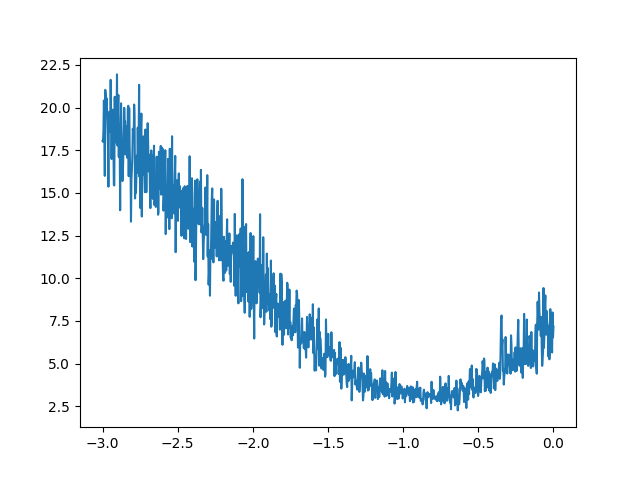

In [45]:
parameters = define_nn()
lrei = []
lossi = []
for p in parameters:
    p.requires_grad = True
for i in range(1000):
    batchix = torch.randint(0, x_all.shape[0], (batchsize,))
    bx, by = x_all[batchix], y_all[batchix]
    loss = forward_pass(bx, by)
    # print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    lrei.append(lre[i])
    lossi.append(loss.item())
plt.figure()
plt.plot(lrei, lossi)

Here, we see the **loss** dropping as the exponent of the learning rate starts to increase, then, after a learning rate of around `0.5`, the **loss** starts to increase. A good rule of thumb is to pick a learning rate whose at a point around which the **loss** is the lowest and most stable, before any increasing tendency. Let's pick the learning rate whose exponent corresponds to the lowest **loss**:

In [46]:
lr = 10**lrei[lossi.index(min(lossi))]
lr

tensor(0.2309)

Now we have some confidence that this is a fairly good learning rate. Now let's train for many epochs using this new learning rate!

In [47]:
_ = train(x_all, y_all, lr=lr, epochs=10000, print_all_losses=False)

2.5242083072662354


Nice. We got a much smaller **loss** after training. We have dramatically improved on the bigram language model, using this simple **nn** of only $3481$ parameters. Now, there's something we have to be careful with. Although our **loss** is the lowest so far, it is not _exactly_ true to say that we now have a better model. The reason is that this is actually a very small model. Even though these kind of models can get much larger by adding more and more parameters, e.g. with $10000$, $100000$ or a million parameters, as the capacity of the **nn** grows, it becomes more and more capable of overfitting your training set. What that means is that the **loss** on the training set (the data that you are training on), will become very very low. As low as $0$. But in such a case, all that the model is doing is memorizing your training set exactly, **verbatim**. So, if you were to take this model and it's working very well, but you try to sample from it, you will only get examples, exactly as they are in the training set. You won't get any new data. In addition to that, if you try to evaluate the **loss** on some withheld names or other input data (e.g. words), you will actually see that the **loss** of those will be very high. And so it is in practice basically not a very good model, since it doesn't generalize. So, it is standard in the field to split up the dataset into $3$ splits, as we call them: the _training_ split (roughly $80\%$ of data), the _dev_/_validation_ split ($10\%$) and the _test_ split ($10\%$).

In [48]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

Now, the training split is used to optimize the parameters of the model (for training). The validation split is typically used for development and tuning over all the hyperparameters of the model, such as the learning rate, layer width, embedding size, regularization parameters, and other settings, in order to choose a combination that works best on this split. The test split is used to evaluate the performance of the model at the end (after training). So, we are only evaluating the **loss** on the test split very very sparingly and very few times. Because, every single time you evaluate your test **loss** and you learn something from it, you are basically trying to also train on the test split. So, you are only allowed to evaluate the **loss** on the test dataset very few times, otherwise you risk overfitting to it as well, as you experiment on your model. Now, let's actually split our dataset into training, validation and test datasets. Then, we are going to train on the training dataset and only evaluate on the test dataset very very sparingly. Here we go:

In [49]:
import random

random.seed(42)
random.shuffle(words)
lenwords = len(words)
n1 = int(0.8 * lenwords)
n2 = int(0.9 * lenwords)
print(f"{lenwords=}")
print(f"{n1} words in training set")
print(f"{n2 - n1} words in validation set")
print(f"{lenwords - n2} words in test")

lenwords=32033
25626 words in training set
3203 words in validation set
3204 words in test


In [50]:
xtrain, ytrain = build_dataset(words[:n1])
xval, yval = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


We now have the $3$ split sets. Great! Let's now re-define our parameters train, anew, on the training dataset:

In [51]:
loss_train = train(xtrain, ytrain, lr=lr, epochs=30000, print_all_losses=False)

2.083573579788208


Awesome. Our **nn** has been trained and the final **loss** is actually surprisingly good. Let's now evaluate the **loss** of the validation set (remember, this data was not in the training set on which it was trained):

In [52]:
loss_val = forward_pass(xval, yval)
loss_val

tensor(2.4294, grad_fn=<NllLossBackward0>)

Not too bad! Now, as you can see, our `loss_train` and `loss_val` are pretty close. In fact, they are roughly equal. This means that we are **not** overfitting, but underfitting. It seems that this model is not powerful enough so as not to be purely memorizing the data. Basically, our **nn** is very tiny. But, we can expect to make performance improvements by scaling up the size of this **nn**. The easiest way to do this is to redefine our **nn** with more neurons in the hidden layer:

In [53]:
parameters = define_nn(l1out=300)

Then, let's re-train and visualize the loss curve:

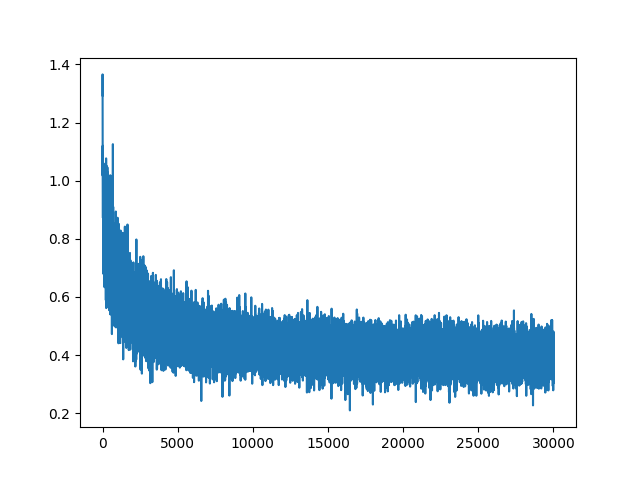

In [54]:
lossi = []
stepi = []
for p in parameters:
    p.requires_grad = True
for i in range(30000):
    batchix = torch.randint(0, xtrain.shape[0], (batchsize,))
    bx, by = xtrain[batchix], ytrain[batchix]
    loss = forward_pass(bx, by)
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
plt.figure()
plt.plot(stepi, lossi)

As you can see, it is a bit noisy, but that is just because of the minibatches!

In [55]:
loss_train = forward_pass(xtrain, ytrain)
loss_val = forward_pass(xval, yval)
print(loss_train)
print(loss_val)

tensor(2.4805, grad_fn=<NllLossBackward0>)
tensor(2.4808, grad_fn=<NllLossBackward0>)


Awesome, the training loss is actually lower than before, whereas the validation loss is pretty much the same. So, increasing the size of the hidden layer gave us some benefit. Let's experiment more to see if we can get even lower losses by increasing the embedding layer. First though, let's visualize the character embeddings:

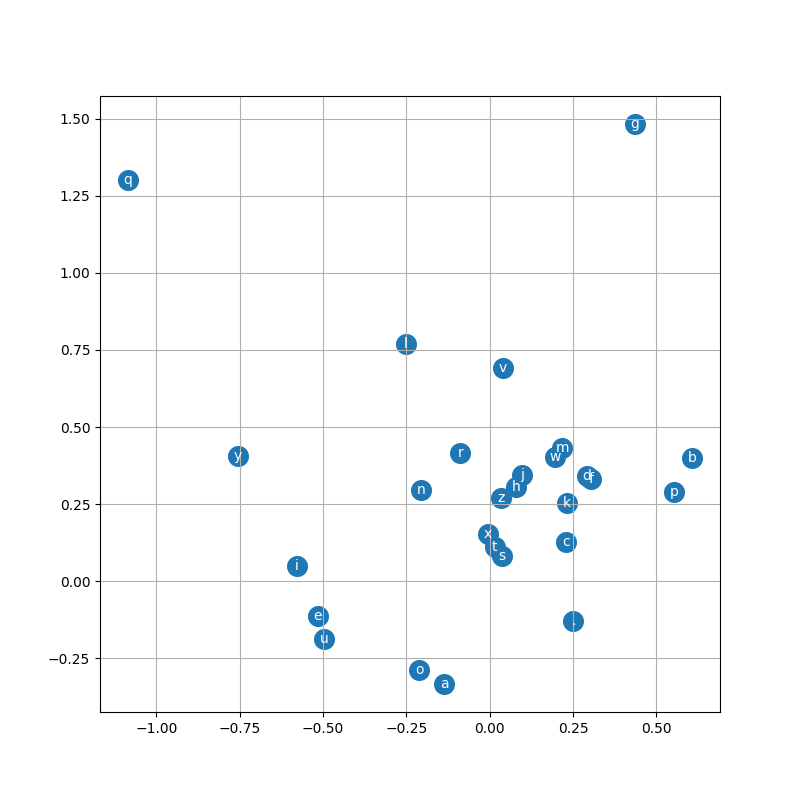

In [56]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        itoc[i],
        ha="center",
        va="center",
        color="white",
    )
plt.grid("minor")

The network has basically learned to separate out the characters and cluster them a little bit. For example, it has learned some characters are usually found more closer together than others. Let's try to improve our model loss by choosing a greater embeddings layer size of $10$ and by increasing the number of epochs to $200000$, also we'll decay the learning rate after $100000$ epochs:

In [57]:
parameters = define_nn(l1out=200, embsize=10)

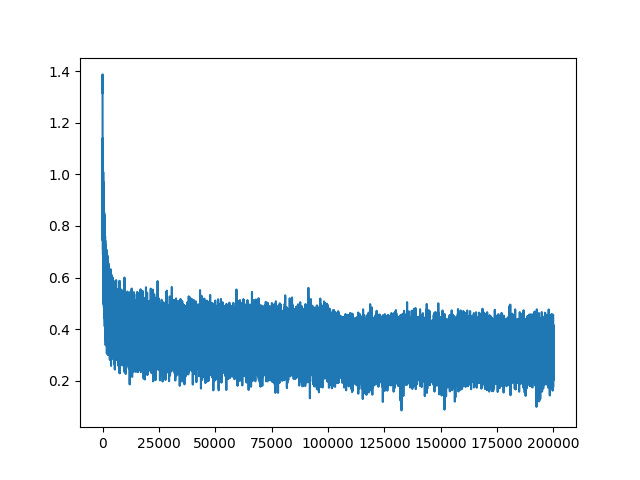

In [58]:
lossi = []
stepi = []
for p in parameters:
    p.requires_grad = True
for i in range(200000):
    batchix = torch.randint(0, xtrain.shape[0], (batchsize,))
    bx, by = xtrain[batchix], ytrain[batchix]
    loss = forward_pass(bx, by)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
plt.figure()
plt.plot(stepi, lossi);

In [59]:
loss_train = forward_pass(xtrain, ytrain)
loss_val = forward_pass(xval, yval)
print(loss_train)
print(loss_val)

tensor(2.1189, grad_fn=<NllLossBackward0>)
tensor(2.1583, grad_fn=<NllLossBackward0>)


Wow, we did it! Both train and validation losses are lower now. Can we go lower? Play around and find out! Now, before we end this lesson, let's sample from our model:

In [60]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itoc[i] for i in out))

mona.
kayah.
see.
med.
ryla.
remmastendrael.
azeer.
melin.
shivonna.
keisen.
anaraelynn.
hotelin.
shaber.
shiriel.
kinze.
jenslenter.
fius.
kavder.
yaralyeha.
kayshayton.


## Outro

As you can see, our model now is pretty decent and able to produce suprisingly name-like text, which is what we wanted all along! Next up, we will explore **mlp** internals and other such magic.